In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
IMAGE_PATH = './Brodatz_examples/'

(640, 640)


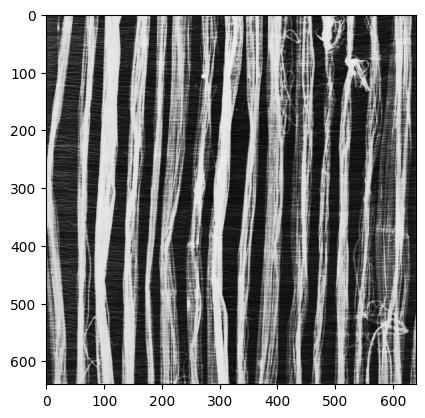

In [6]:
textura = plt.imread(IMAGE_PATH+'D51.bmp')
textura = cv2.cvtColor(textura, cv2.COLOR_RGB2GRAY)
plt.imshow(textura, cmap=plt.cm.gray)
print(textura.shape)

In [4]:
def getPatches(image: np.ndarray, locations: list, patch_size=20) -> list:
    res = []
    for loc in locations:
        res.append(image[loc[0] : loc[0] + patch_size, loc[1] : loc[1] + patch_size])
    return res


In [7]:
texel_size = 20
ubicacion_texels = [(0,0),(200,150),(250,350)]
texels = getPatches(textura, ubicacion_texels,60)

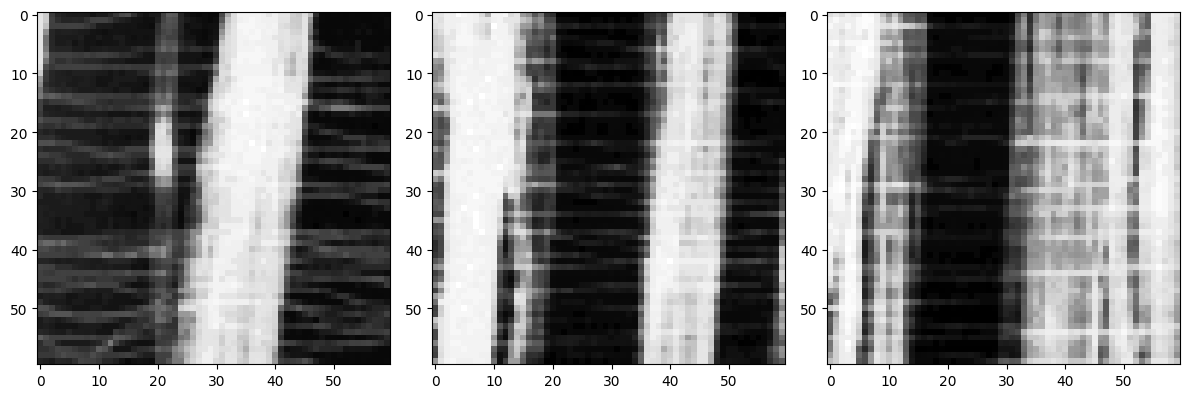

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.ravel()
for ix in range(3):
    ax[ix].imshow(texels[ix], cmap=plt.cm.gray)
fig.tight_layout()
plt.show()


In [10]:
glcm = graycomatrix(texels[0],distances=[5],angles=[0],levels=256,symmetric= True, normed=True)
print(np.mean(glcm))

1.5258789062499998e-05


In [11]:
def getFeatureVector(texel: np.ndarray, stats: list):
    
    glcm = graycomatrix(texel,distances=[5],angles=[0],levels=256,symmetric=True, normed=True)
    vect = [np.mean(glcm)]
    
    for stat in stats:
        vect.append(graycoprops(glcm,prop=stat)[0,0])
    return vect
    # return [
    #     graycoprops(glcm,prop='contrast')[0,0],
    #     graycoprops(glcm,prop='dissimilarity')[0,0],
    #     graycoprops(glcm,prop='homogeneity')[0,0],
    #     graycoprops(glcm,prop='ASM')[0,0],
    #     graycoprops(glcm,prop='energy')[0,0],
    #     graycoprops(glcm,prop='correlation')[0,0],
    #     ]
    

In [12]:
def sliding_window(image, stepSize, windowSize):
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield(x,y,image[y:y+windowSize[1],x:x+windowSize[0]])

In [13]:
def getTrainingData(texels: list, stats: list[str] ) -> list:
  vectors = []
  for tx in texels:
    # for (x,y,window) in sliding_window(tx,5,(40,40)):
    #   vectors.append(getFeatureVector(window))
    vectors.append(getFeatureVector(tx,stats))
  return vectors

In [14]:
def getTexelData(image_path: str, stats = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']):
  textura = plt.imread(IMAGE_PATH+image_path)
  textura = cv2.cvtColor(textura, cv2.COLOR_RGB2GRAY)
  
  ubicacion_texels = [(0,0),(200,150),(250,350),(100,100),(50,400),(400,100),(300,120),
                      (123,342),(421,111),(23,33),(265,31),(78,473),(300,300),(400,212)]
  texels = getPatches(textura, ubicacion_texels,40)
  return getTrainingData(texels,stats)

In [15]:
def evaluarClasificador(clasificador, imagen, windowStep, windowSize,stats = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']):
  colores = [[57, 17, 181], [17, 148, 145], [149, 206, 195], [244, 116, 168], [58, 202, 75], [210, 29, 24], [110, 20, 248], [246, 190, 17]]
  res = np.zeros(shape=imagen.shape)
  res = np.dstack([res,res,res])
  for(x,y,window) in sliding_window(imagen,windowStep,windowSize):
    
    vector = getFeatureVector(window,stats)
    
    color_prediction = colores[int(clasificador.predict([vector]))]
    for iy in range(y,y+10):
      for ix in range(x,x+10):
        if (ix < res.shape[1] and iy < res.shape[0]):
          res[iy,ix] = color_prediction
    
  return res

In [18]:
# ['dissimilarity','homogeneity','ASM','energy'] prueba 1

prueba1 = ['dissimilarity','homogeneity','ASM','energy']
prueba2 = ['contrast','dissimilarity','energy','correlation']
images  = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
tr_data = []
tr_lbls = []
for img in images:
  tr_data += getTexelData(img,prueba1)
tr_lbls = [i//(len(tr_data)//8) for i in range(len(tr_data))]

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(tr_data,tr_lbls)


gnb = GaussianNB()
gnb.fit(tr_data,tr_lbls)

svm = SVC()
svm.fit(tr_data,tr_lbls)

SVC()

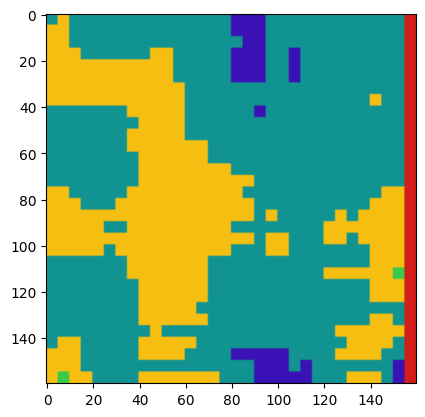

In [20]:
img1 = plt.imread('./Brodatz_examples/D17.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
test1 = evaluarClasificador(neigh,img1[480:,480:],5,(40,40),prueba1)
plt.imshow(test1.astype(int))

In [407]:
plt.imsave('./variacion_estadisticos/D17_todos_knn.png',test1.astype(np.uint8))

7


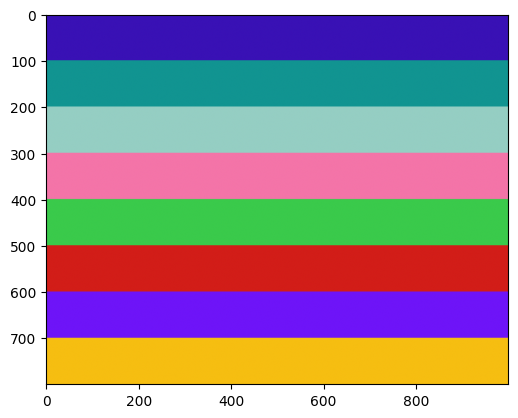

In [ ]:
colores = [[57, 17, 181], [17, 148, 145], [149, 206, 195], [244, 116, 168], [58, 202, 75], [210, 29, 24], [110, 20, 248], [246, 190, 17]]
imagen = np.zeros(shape=(800,1000))
imagen = np.dstack([imagen,imagen,imagen])
print(757//100)
for ix in range(imagen.shape[0]):
  for iy in range(imagen.shape[1]):
    imagen[ix,iy] = colores[ix//100]
    
plt.imshow(imagen/255)

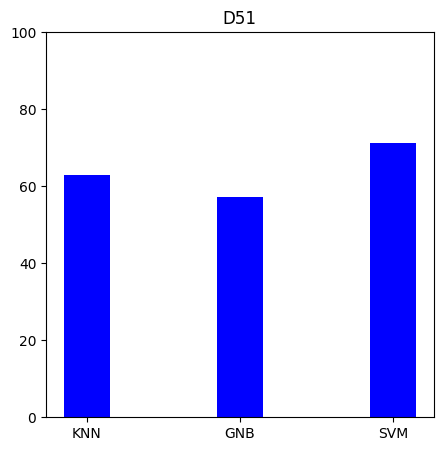

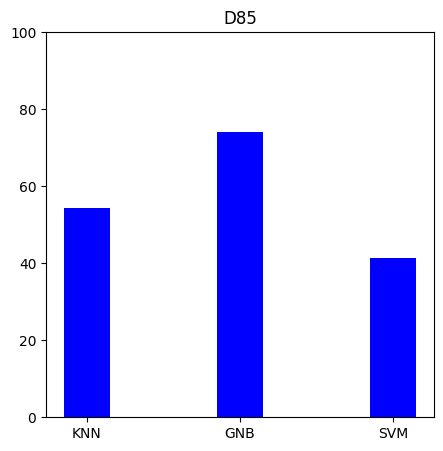

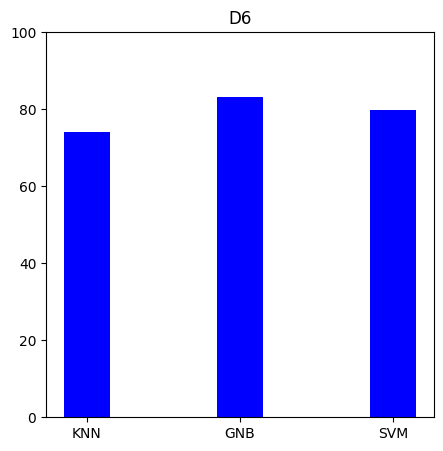

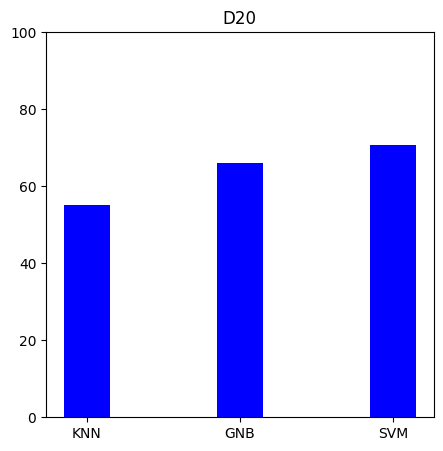

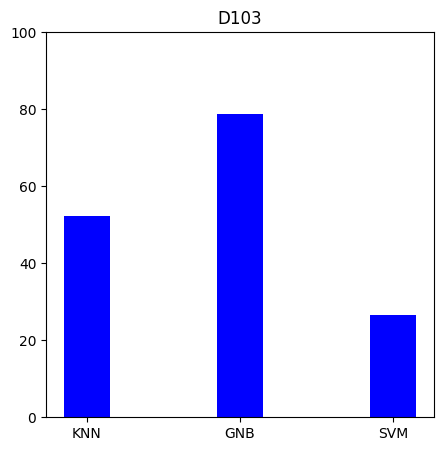

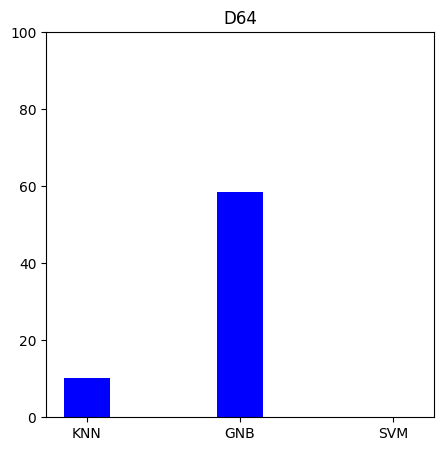

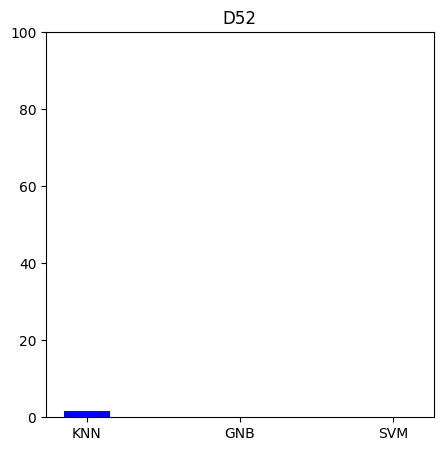

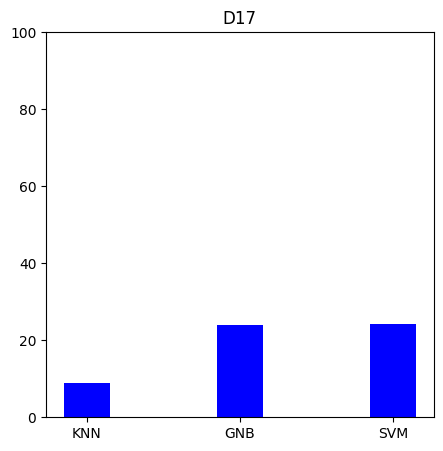

In [324]:
clasificadores = [neigh, gnb, svm]
lbl = ['KNN','GNB','SVM']
images = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
colores = [[57, 17, 181], [17, 148, 145], [149, 206, 195], [244, 116, 168], [58, 202, 75], [210, 29, 24], [110, 20, 248], [246, 190, 17]]

for key_img,img_path in enumerate(images):
  img = plt.imread('./Brodatz_examples/'+img_path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  precision = [0,0,0]
  for key,clasificador in enumerate(clasificadores):
    test = evaluarClasificador(clasificador,img[480:,480:],5,(40,40))
    test = test.astype(int)
    for ix in range(test.shape[0]):
      for iy in range(test.shape[1]):
        color = test[ix,iy]
        precision[key] += 1 if (color == colores[key_img]).all() else 0
  accuracy = np.array(precision) / (160*160) * 100
  name = img_path.split('.')[0] + '_resultados.png'  
  fig = plt.figure(figsize=(5,5))
  plt.bar(lbl,accuracy,color='blue',width=0.3)
  plt.ylim(0,100)
  plt.title(img_path.split('.')[0])
  plt.savefig('./resultados3/'+name)

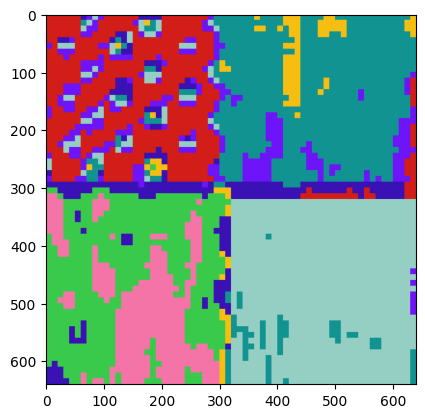

In [ ]:
images = ['D51.bmp','D85.bmp','D6.bmp','D20.bmp','D103.bmp','D64.bmp','D52.bmp','D17.bmp']
compuesta = plt.imread('./imagenes_combinadas/textura_compuesta3.bmp')
compuesta = cv2.cvtColor(compuesta, cv2.COLOR_RGB2GRAY)

res = evaluarClasificador(gnb,compuesta,  10, (40,40))
plt.imshow(res.astype(int))

In [414]:
a = plt.imread('./Brodatz_examples/D17.bmp')
plt.imsave('variacion_estadisticos/D17.png',a)